In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras import losses, optimizers

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Preprocessing function to get data aranged for time-series predictions
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
# Date parser 
def parse(x):
    return pd.datetime.strptime(x,'%d %m %Y')

# Load data
dataset_original = pd.read_csv('COLCAP_2.csv', parse_dates = [['Day', 'Month', 'Year']], index_col=0, date_parser=parse)

# Remove last 4 values to get round number
dataset_original.drop(dataset_original.tail(4).index, inplace=True)

# manually specify column names
dataset_original.columns = ['COLCAP', 'Var_Abs', 'Var_Por']
dataset_original.index.name = 'Date'

# Get dates to get day of the week
# Monday = 1, Sunday = 7
days = pd.DataFrame(dataset_original.index)
days['Weekday'] = days['Date'].dt.dayofweek+1
days = days.set_index('Date')

# Drop variation colums from dataset
dataset_new = dataset_original.copy()
dataset_new = dataset_new.drop(dataset_new.columns[[1,2]], axis=1)

In [4]:
# Get values to scale
data_values = dataset_new.values
day_values = days.values

# Make everything float
data_values = data_values.astype('float32')
day_values = day_values.astype('float32')

# Normalize features
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler1.fit_transform(data_values)
day_scaled = scaler2.fit_transform(day_values)

# Number of days to use
n_days = 10

# Training days, validation days, testing days
n_train = 1600
n_val = 600
n_test = len(dataset_original) - (n_train+n_val)

# Frame COLCAP values for supervised learning
# series_to_supervised(data, n_in=1, n_out=1, dropnan=True)
data_framed = series_to_supervised(data_scaled,n_days,1)

# Add day of the week to framed data
#data_framed.insert(5,'Day',day_scaled[5:])

In [5]:
# Get values of reframed
framed_values = data_framed.values

# Split into train, validate, and test
train = framed_values[:n_train,:]
validate = framed_values[n_train:(n_train+n_val),:]
test = framed_values[(n_train+n_val):(n_train+n_val+n_test),:]

# Split into inputs and outputs
train_x, train_y = train[:, :-1], train[:, -1]
val_x, val_y = validate[:, :-1], validate[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]

print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

(1600, 10) (1600,) (600, 10) (600,) (295, 10) (295,)


In [6]:
# If an LSTM network is going to be used, the data has to be reshaped
# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], n_days, 1))
val_x = val_x.reshape((val_x.shape[0], n_days, 1))
test_x = test_x.reshape((test_x.shape[0], n_days, 1))

print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

(1600, 10, 1) (1600,) (600, 10, 1) (600,) (295, 10, 1) (295,)


In [7]:
# design network
model = Sequential()
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
#model.add(LSTM(175, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss=losses.mean_squared_error, optimizer='adam', metrics = ['accuracy'])

# Epochs & Mini-Batches
epochs = 100
batch_size = 50

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 300)           362400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 200)           400800    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 883,701
Trainable params: 883,701
Non-trainable params: 0
_________________________________________________________________


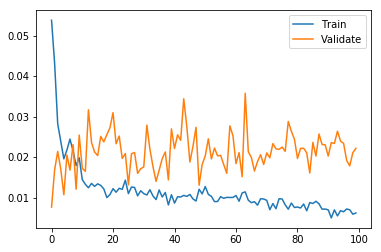

Validation Loss =  0.02215577781200409
Validation Accuracy =  0.0


In [8]:
# fit network
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_x, val_y), verbose=0, shuffle=True)

# Validate model
score_val = model.evaluate(val_x,val_y,verbose=0)

# plot history
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validate')
plt.legend()
plt.show()

# Print validation
print('Validation Loss = ', score_val[0])
print('Validation Accuracy = ', score_val[1])

Test RMSE: 214.931


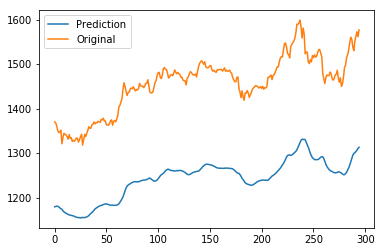

In [9]:
# make a prediction
yhat = model.predict(test_x)

# Invert normalization
inv_yhat = scaler1.inverse_transform(yhat)

# Create vector for x axis
t = range(len(inv_yhat))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(dataset_new[-len(inv_yhat):], inv_yhat))
print('Test RMSE: %.3f' % rmse)

# Plot Prediction and Real
plt.plot(t,inv_yhat,label='Prediction')
plt.plot(t,dataset_new[-295:],label='Original')
plt.legend(loc='best')